### Step 4
Do the same as Step 3 when instead a context-generation approach is adopted to identify the classes of customers and adopt a potentially different pricing strategy per class. In doing that, evaluate the performance of the pricing strategies in the different classes only at the optimal solution (e.g., if prices that are not optimal for two customers’ classes provide different performance, you do not split the contexts). Let us remark that no discrimination of the customers’ classes is performed at the advertising level. From this Step on, choose one approach between the upper-confidence bound one and the Thompson-sampling one.

In [171]:
import numpy as np

# Abstract-Super class of Learner
class Learner():
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.price = np.linspace(3.0, 15.0, self.n_arms) 
        self.t = 0  #Time 
        self.rewards_per_arm = x = [[] for i in range(n_arms)]
        self.collected_rewards = []
    
    def update_observations(self, pulled_arm, reward):
        self.rewards_per_arm[pulled_arm].append(reward)
        self.collected_rewards.append(reward)

##################################   LEARNERS    ##################################
# Thompson-Sampling Learner

class TS_Learner(Learner):
    def __init__(self, n_arms, safety_t = 0.2):
        super().__init__(n_arms)
        self.safety_t = safety_t
        #Mean and Std
        self.normal_parameters = np.zeros((self.n_arms, 2))

    def pull_arm(self):
        if self.t < (2*self.n_arms): return (self.t % self.n_arms)

        #Safety constraint
        #Alternative implementation safety constraints using MATH         
        arg_max = []
        for p in self.normal_parameters : 
            if 0.5 * erfc(p[0]/(np.sqrt(2)*p[1])) > self.safety_t :
                arg_max.append(0.0) 
            else : 
                arg_max.append(np.random.normal(p[0], p[1]))
    
        return np.argmax(arg_max)

    def update(self, pulled_arm, reward):
        self.t += 1
        times_pulled = max(1, len(self.rewards_per_arm[pulled_arm]))
        self.update_observations(pulled_arm, reward)
        #Empirical mean
        self.normal_parameters[pulled_arm, 0] = (self.normal_parameters[pulled_arm, 0] * (times_pulled - 1) + reward ) / times_pulled
        #Empirical std
        #NOt gooooood Should depend on the number of sampl (inversionally proportional)
        self.normal_parameters[pulled_arm, 1] = np.sqrt(sum((self.normal_parameters[pulled_arm, 0] - self.rewards_per_arm[pulled_arm])**2)/times_pulled**2)

# Upper-Confidence Bound Learner
class UCB1(Learner):
    def __init__(self, n_arms):
        super().__init__(n_arms)
        self.empirical_means = np.zeros(n_arms)
        self.confidence = np.zeros(n_arms)

    def pull_arm(self):
        if self.t < self.n_arms:
            return self.t 
        upper_bound = self.empirical_means + self.confidence
        return np.random.choice(np.where(upper_bound == upper_bound.max())[0])
    
    def update(self, pulled_arm, reward):
        self.t += 1
        self.rewards_per_arm[pulled_arm].append(reward)
        self.collected_rewards.append(reward)
        self.empirical_means[pulled_arm] = (self.empirical_means[pulled_arm] * (self.t-1) + reward)/self.t
        for a in range(self.n_arms):
            number_pulled = max(1, len(self.rewards_per_arm[a]) ) 
            self.confidence[a] = (2*np.log(self.t) /number_pulled)**0.5

### Main for the experiment

Here data is NOT aggregated

In [173]:
from environment import Environment
from scipy.special import erfc

env = Environment()
n_arms = 13
ucb1_learner_c0 = UCB1(n_arms = n_arms)
ucb1_learner_c1 = UCB1(n_arms = n_arms)
ucb1_learner_c2 = UCB1(n_arms = n_arms)
ts_learner_c0 = TS_Learner(n_arms = n_arms)
ts_learner_c1 = TS_Learner(n_arms = n_arms)
ts_learner_c2 = TS_Learner(n_arms = n_arms)

T = 365
opt_bids = [3.8622484787564275 , 2.1216094606111944,  2.347134281066495]
opt_price = 6.321089806558111
regret_c0_ucb = []
regret_c1_ucb = []
regret_c2_ucb = []

regret_c0_ts = []
regret_c1_ts = []
regret_c2_ts = []

# Use this for testing, the price learned is 7, the optimal one
bids = opt_bids 
prices = np.linspace(3.0, 15.0, n_arms)

price_ev_per_day_ucb = []
price_ev_per_day_ts = []

for day in range(T):
    #UCB1 learner
    price_c0_idx = ucb1_learner_c0.pull_arm()
    price_c0 = prices[price_c0_idx]
    price_c1_idx = ucb1_learner_c1.pull_arm()
    price_c1 = prices[price_c1_idx]
    price_c2_idx = ucb1_learner_c2.pull_arm()
    price_c2 = prices[price_c2_idx]
    
    reward_per_day = []
    price = [price_c0, price_c1, price_c2]
    for i in range(len(price)):
        p = price[i]
        reward = env.round(bids, p)
        reward_per_day.append(reward[i]) 

    ucb1_learner_c0.update(price_c0_idx, reward_per_day[0])
    ucb1_learner_c1.update(price_c1_idx, reward_per_day[1])
    ucb1_learner_c2.update(price_c2_idx, reward_per_day[2])
    
    reward_optimal = env.round(opt_bids, opt_price, noise= False)
    regret_c0 = reward_optimal[0] - reward_per_day[0]
    regret_c1 = reward_optimal[1] - reward_per_day[1]
    regret_c2 = reward_optimal[2] - reward_per_day[2]
    regret_c0_ucb.append(regret_c0)
    regret_c1_ucb.append(regret_c1)
    regret_c2_ucb.append(regret_c2)

    price_ev_per_day_ucb.append(price)

    #TS learner
    price_c0_idx = ts_learner_c0.pull_arm()
    price_c0 = prices[price_c0_idx]
    price_c1_idx = ts_learner_c1.pull_arm()
    price_c1 = prices[price_c1_idx]
    price_c2_idx = ts_learner_c2.pull_arm()
    price_c2 = prices[price_c2_idx]
    
    reward_per_day = []
    price = [price_c0, price_c1, price_c2]
    for i in range(len(price)):
        p = price[i]
        reward = env.round(bids, p)
        reward_per_day.append(reward[i]) 

    ts_learner_c0.update(price_c0_idx, reward_per_day[0])
    ts_learner_c1.update(price_c1_idx, reward_per_day[1])
    ts_learner_c2.update(price_c2_idx, reward_per_day[2])
    
    reward_optimal = env.round(opt_bids, opt_price, noise= False)
    regret_c0 = reward_optimal[0] - reward_per_day[0]
    regret_c1 = reward_optimal[1] - reward_per_day[1]
    regret_c2 = reward_optimal[2] - reward_per_day[2]
    regret_c0_ts.append(regret_c0)
    regret_c1_ts.append(regret_c1)
    regret_c2_ts.append(regret_c2)

    price_ev_per_day_ts.append(price)


## Plots

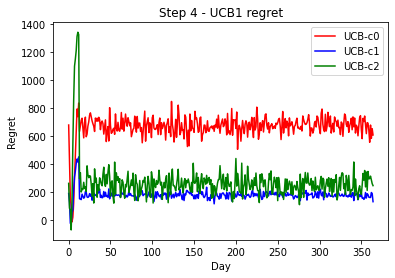

In [175]:
import matplotlib.pyplot as plt 

plt.figure(0)
plt.xlabel("Day")
plt.ylabel("Regret")
plt.plot(regret_c0_ucb,'r', label="UCB-c0")
plt.plot(regret_c1_ucb, 'b', label="UCB-c1")
plt.plot(regret_c2_ucb, 'g', label="UCB-c2")
plt.title("Step 4 - UCB1 regret")
plt.legend()
plt.show()


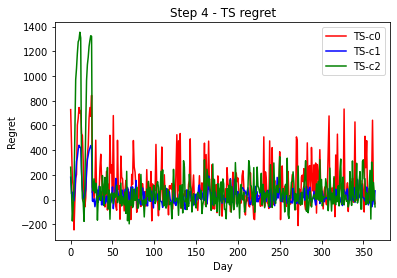

In [177]:
import matplotlib.pyplot as plt 

plt.figure(1)
plt.xlabel("Day")
plt.ylabel("Regret")
plt.plot(regret_c0_ts,'r', label="TS-c0")
plt.plot(regret_c1_ts, 'b', label="TS-c1")
plt.plot(regret_c2_ts, 'g', label="TS-c2")
plt.title("Step 4 - TS regret")
plt.legend()
plt.show()

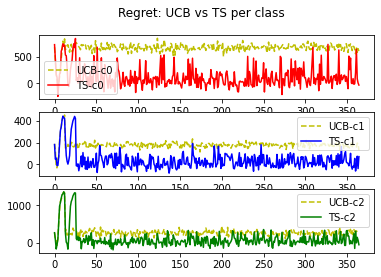

In [179]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3)
fig.suptitle('Regret: UCB vs TS per class')
axs[0].plot(regret_c0_ucb,'y', label="UCB-c0", linestyle="dashed")
axs[0].plot(regret_c0_ts,'r', label="TS-c0")
axs[0].legend()
axs[1].plot(regret_c1_ucb,'y', label="UCB-c1", linestyle="dashed")
axs[1].plot(regret_c1_ts,'b', label="TS-c1")
axs[1].legend()
axs[2].plot(regret_c2_ucb,'y', label="UCB-c2", linestyle="dashed")
axs[2].plot(regret_c2_ts,'g', label="TS-c2")
axs[2].legend()

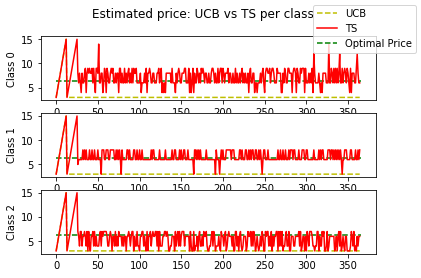

In [181]:
import matplotlib.pyplot as plt
import numpy as np

YY_ucb = np.array(price_ev_per_day_ucb) 
YY_ts = np.array(price_ev_per_day_ts)

fig, axs = plt.subplots(3)
fig.suptitle('Estimated price: UCB vs TS per class')
axs[0].plot(YY_ucb[:,0],'y', linestyle="dashed")
axs[0].plot(YY_ts[:,0],'r')
axs[0].hlines(opt_price, 0, 365, 'g', linestyles='dashed')
axs[0].set(ylabel="Class 0")
axs[1].plot(YY_ucb[:,1],'y', linestyle="dashed")
axs[1].plot(YY_ts[:,1],'r')
axs[1].hlines(opt_price, 0, 365, 'g', linestyles='dashed')
axs[1].set(ylabel="Class 1")
axs[2].plot(YY_ucb[:,2],'y', linestyle="dashed")
axs[2].plot(YY_ts[:,2],'r')
axs[2].hlines(opt_price, 0, 365, 'g', linestyles='dashed')
axs[2].set(ylabel="Class 2")
fig.legend(["UCB","TS","Optimal Price"])

In [183]:
regret_c0_ts[-10:]


[5.984280661365801,
 -4.164553806240292,
 90.2456647509598,
 -17.207844522351024,
 -5.076783784236568,
 199.99636390484739,
 642.6602497689126,
 86.05784876952953,
 8.064533568565366,
 -31.885926030327028]

In [185]:
regret_c1_ts[-10:]

[-17.526437788782516,
 -42.64906307554958,
 -15.739523438175866,
 -25.147070718367104,
 55.51417099133505,
 -59.716446457804295,
 -10.470002286840156,
 75.10986256611008,
 -37.536755630449306,
 71.31557691857597]

In [186]:
regret_c2_ts[-10:]

[-14.95169295320477,
 -33.299691908743284,
 101.91885584091744,
 236.74387269018655,
 -157.32514948408823,
 303.59652911031264,
 -8.22304117132478,
 139.54476692154492,
 62.04762661219672,
 -58.205636905670985]